In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs,make_moons,make_circles
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM as OCSVM
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn import datasets

In [52]:
X, Y = make_circles(n_samples=30,factor=0.1,noise=0.4,random_state=5)
X=X+3

In [53]:
X1=X[Y==1]
Y1=Y[Y==1]

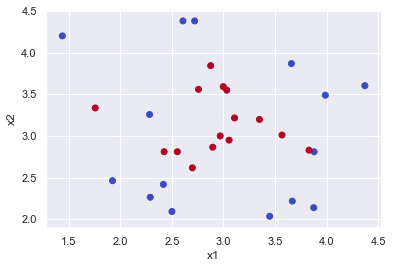

In [54]:
sns.set()
_=plt.scatter(X[:,0],X[:,1],c=Y, cmap='coolwarm')
plt.margins(0.05)
_=plt.xlabel('x1')
_=plt.ylabel('x2')
plt.show()

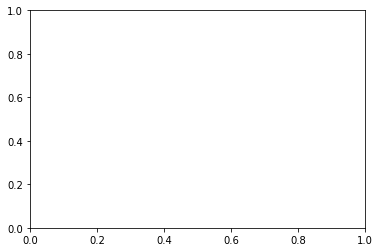

In [6]:
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(0, 5, 30)
yy = np.linspace(0, 6, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

In [7]:
class FzOCSVM:
    def __init__(self,n_alpha,kernel):
        self.n_alpha=n_alpha
        self.kernel=kernel
        self.alpha=np.linspace(0,1,self.n_alpha)
        self.fuzz_points=[]
        self.ffy=[]
        self.fdata=[]
        self.fY=[]
        self.cff_list=[]
        self.rho_list=[]
        self.weight=[]
        self.bias=[]
        self.clf2=OCSVM(kernel=self.kernel)
        self.SV_list=[]
        self.w=[]
        self.b=[]
        self.fw=[]
        self.fb=[]
    
    def Gen_lb_ub(self,x):
        lb=x-0.02*x
        ub=x+0.03*x
        return lb,ub
    
    def Gen_cen_ran(self,lb,ub):
        cen=(ub+lb)/2
        ran=(ub-lb)/2
        return cen,ran
    
    def Fuzzify(self,cen,ran,alpha):
        a=cen-ran*(1-alpha)
        b=cen+ran*(1-alpha)
        return a,b
    
    def Gen_setx(self,a,b,c,y,ffy):
        #print("in gen set x")
        for i in range(40):
            self.fuzz_points.append([np.random.uniform(a,b),c])
            self.fY.append(y)
            #self.ffy.append(y)
        self.fuzz_points.append([a,c])
        self.fuzz_points.append([b,c])
        self.fY.append(y)
        self.fY.append(y)
        #print(self.fuzz_points)
        #self.ffy.append(y)
        #self.ffy.append(y)
    
    def Gen_sety(self,a,b,c,y,ffy):
        for i in range(40):
            self.fuzz_points.append([c,np.random.uniform(a,b)])
            self.fY.append(y)
            #self.ffy.append(y)
        self.fuzz_points.append([c,a])
        self.fuzz_points.append([c,b])
        self.fY.append(y)
        self.fY.append(y)
        #self.ffy.append(y)
        #self.ffy.append(y)
        
    #function to plot the data points for each alpha
    def plot_data(self,x,y):
        lb,ub=self.Gen_lb_ub(x)
        cen,ran=self.Gen_cen_ran(lb,ub)
        for i in range(11):
            #global fuzz_points
            self.fuzz_points=[]
            a,b=self.Fuzzify(cen,ran,self.alpha[i])
            self.Gen_setx(a[0],b[0],a[1],y,self.ffy)
            self.Gen_setx(a[0],b[0],b[1],y,self.ffy)
            self.Gen_sety(a[1],b[1],a[0],y,self.ffy)
            self.Gen_sety(a[1],b[1],b[0],y,self.ffy)
            self.fdata.extend(self.fuzz_points)
            #print(len(fdata))
            fuzz_points_new=np.array(self.fuzz_points)
            #print(fuzz_points_new[:,:])
            t=(y,1-self.alpha[i],1-self.alpha[i])
            #plt.scatter(i,i,color=(0,alpha[i],alpha[i]))
            plt.scatter(fuzz_points_new[:,0],fuzz_points_new[:,1],color=t,s=2,cmap='coolwarm')
            #print(alpha[i])
    
    def plot_svc_decision_function(self,model,X,Y, ax=None,
        plot_support=True,alpha_value=0.7):
        """Plot the decision function for a 2D SVC"""
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)
        #plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        #create grid to evaluate model
        Z = model.decision_function(xy).reshape(XX.shape)
        #plot decision boundary and margins
        ax.contour(XX, YY, Z, """colors=(alpha_value,alpha_value,alpha_value)""", levels=[-1, 0,1], alpha=1,linestyles=['--', '-', '--'])
        #plot support vectors
        #ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
        # linewidth=1, facecolors='none', edgecolors='k',alpha=1-alpha_value)
        #plt.show()
    def predict(self,X,Y,index):
        rbf=RBF()
        SV=self.SV_list[index]
        val=0
        distances=[]
        y_pred=[]
        n=len(X)
        m=len(SV)
        for i in range(n):
            val=0
            for j in range(m):
                B=[]
                C=[]
                B.append(SV[j])
                C.append(X[i])
                result=rbf.__call__(B,C)
                #print(result)
                val=val+self.cff_list[index][j]*result[0][0]
            val=val+self.rho_list[index]
            distances.append(val)
            if val>0:
                y_pred.append(1)
            elif val<0:
                y_pred.append(0)
        y_pred=np.array(y_pred)
        return y_pred,distances
    
    def main(self,X,Y,n_samples):
        for i in range(self.n_alpha):
            #global fuzz_points
            self.fuzz_points=[]
            #global ffy
            self.ffy=[]
            t=[]
            for j in range(n_samples):
                lb,ub=self.Gen_lb_ub(X[j])
                cen,ran=self.Gen_cen_ran(lb,ub)
                a,b=self.Fuzzify(cen,ran,self.alpha[i])
                self.Gen_setx(a[0],b[0],a[1],Y[j],self.ffy)
                #print(self.fuzz_points,j)
                self.Gen_setx(a[0],b[0],b[1],Y[j],self.ffy)
                self.Gen_sety(a[1],b[1],a[0],Y[j],self.ffy)
                self.Gen_sety(a[1],b[1],b[0],Y[j],self.ffy)
                #print(self.fuzz_points)
                self.fdata.extend(self.fuzz_points)
                #x1=np.linspace(2,5)
                self.fuzz_points_new=np.array(self.fuzz_points)
            #X_train,X_test,Y_train,Y_test=train_test_split(fuzz_points,ffy,test_size=0.3,random_state=1)
            self.clf2.fit(self.fuzz_points)
            cff=self.clf2.dual_coef_[0]
            rho=self.clf2.intercept_[0]
            sv=self.clf2.support_vectors_
            self.cff_list.append(cff)
            self.rho_list.append(rho)
            self.SV_list.append(sv)
            #y_pred,distances=self.predict(X,Y,i)
            #print((y_pred==Y).mean())
            #m=-w[0][0]/w[0][1]
            #x2=m*x1-b[0]/w[0][1]
            #SV=clf2.support_vectors_
            #x2=0
            self.plot_svc_decision_function(self.clf2,X,Y,alpha_value=self.alpha[i])
        self.deFuzzify()
        #plt.scatter(X[0,:],X[1,:],c=Y)
        #plt.show()
        #for i in range(len(SV)):
        #x2=x2+cff[i]*rbf.__call__(SV[i],)
        #plt.plot(x1,x2,c=(1-alpha[i],1-alpha[i],1-alpha[i]),linewidth=1.0)
        #plt.scatter(SV[:,0],SV[:,1],s=300,lw=1,c=(1-alpha[i],1-alpha[i],1-alpha[i]),facecolors='none')
        #print(SV)
    
    def deFuzzify(self):
        n=min(list(map(len,self.cff_list)))
        for j in range(n):
            d={}
            for i in range(len(self.cff_list)):
                #if self.cff_list[i][j] not in d.keys():
                d[self.cff_list[i][j]]=[]
            for i in range(len(self.cff_list)):
                d[self.cff_list[i][j]].append(self.alpha[i])
            self.w=[]
            self.fw=[]
            for (key,value) in d.items():
                maxalpha=max(value)
                self.fw.append(maxalpha)
                self.w.append(key)
            output=np.trapz(y=self.fw,x=self.w)
            self.weight.append(output)
        r={}
        for i in range(len(self.rho_list)):
            if self.rho_list[i] not in r:
                r[self.rho_list[i]]=[]
        for i in range(len(self.rho_list)):
            r[self.rho_list[i]].append(self.alpha[i])
        self.b=[]
        self.fb=[]
        for (key,value) in r.items():
            maxalpha=max(value)
            self.fb.append(maxalpha)
            self.b.append(key)
        output=np.trapz(y=self.fb,x=self.b)
        self.bias=output

In [8]:
fob=FzOCSVM(n_alpha=11,kernel='rbf')

C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

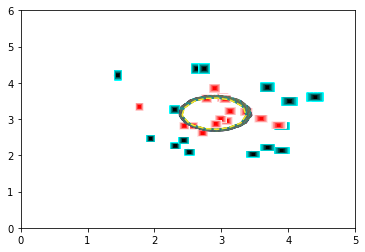

In [9]:
fob.main(X1,Y1,len(X1))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)
for i in range(30):
    fob.plot_data(X[i],Y[i])
plt.show()

In [10]:
y_pred,distances=fob.predict(X,Y,2)

In [11]:
print((y_pred==Y).mean())

0.8


In [12]:
clf1=OCSVM()
clf1.fit(X1)
y_pred1=clf1.predict(X)
print((y_pred1==Y).mean())

0.2


C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
print(len(fob.SV_list[6]))
print(len(fob.weight))

1261
1261


In [14]:
def plot_svc_decision_function(model,X,Y, ax=None, plot_support=True,alpha_value=0.7):
    """Plot the decision function for a 2D SVC"""
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)
    #plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    #create grid to evaluate model
    Z = model.decision_function(xy).reshape(XX.shape)
    #plot decision boundary and margins
    ax.contour(XX, YY, Z, """colors=(alpha_value,alpha_value,alpha_value)""", levels=[-1, 0,1], alpha=1,linestyles=['--', '-', '--'])
    #plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
    linewidth=1, facecolors='none', edgecolors='k',alpha=1-alpha_value)
    plt.show()

1261


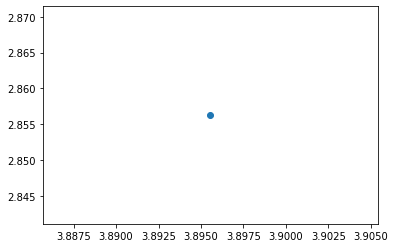

In [15]:
#cnt=0
#for SV in fob.SV_list:
# print(cnt)
# for i in range(len(SV)):
# plt.scatter([SV[i][0]],[SV[i][1]])
# cnt=cnt+1
#plt.show()
k=min(list(map(len,fob.SV_list)))
print(k)
s=fob.alpha.sum()
n=len(fob.SV_list)
defzSV=[]
for j in range(k):
    arr=np.array([0,0])
    arr2=np.array([0,0])
for i in range(n):
    arr=arr+fob.SV_list[i][j]
    arr2=arr2+fob.alpha[i]*fob.SV_list[i][j]
#plt.scatter([arr[0]],[arr[1]])
arr=arr/n
arr2=arr2/s
defzSV.append(arr2)
plt.scatter([arr[0]],[arr[1]])
#plt.scatter([arr2[0]],[arr2[1]])
plt.show()

In [16]:
print(len(fob.fdata))

277200


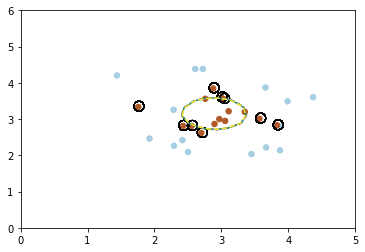

In [17]:
#fob.clf2.fit(fob.fdata)
plot_svc_decision_function(fob.clf2,X,Y)

In [18]:
def pre_process(X,Y,cls):
    X1=[]
    Y1=[]
    for i in range(len(X)):
        if Y[i]==cls:
            X1.append(X[i])
            Y1.append(Y[i])
    X1=np.array(X1)
    Y1=np.array(Y1)
    return X1,Y1

In [19]:
iris=datasets.load_iris()
X2,Y2=pre_process(iris.data[:,:2],iris.target,2)

C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ANWOY\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: No contour levels were found within the data range.
C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ANWOY\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: No contour levels were found within the data range.
C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will cha

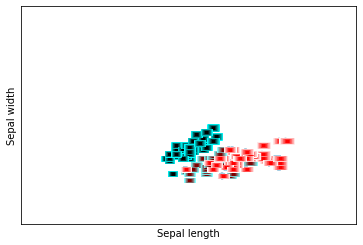

In [20]:
x_min, x_max = iris.data[:, 0].min() - .5, iris.data[:, 0].max() + .5
y_min, y_max = iris.data[:, 1].min() - .5, iris.data[:, 1].max() + .5
fob2=FzOCSVM(n_alpha=11,kernel='rbf')
fob2.main(X2,Y2,len(X2))
for i in range(len(iris.data[:,0])):
    fob2.plot_data(iris.data[i,:2],iris.target[i]/2)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xticks(())
plt.yticks(())
plt.show()

In [21]:
def evaluate(cls,y_pred):
    cnt=0
    n=len(iris.data[:,0])
    for i in range(len(iris.data[:,0])):
        if iris.target[i] == cls and y_pred[i]==1:
            cnt=cnt+1
        elif iris.target[i] != cls and y_pred[i]==0:
            cnt=cnt+1
    return cnt/n

In [22]:
y_pred2,distances2=fob2.predict(iris.data[:,:2],iris.target,1)
result=evaluate(2,y_pred2)
print(result)

0.7266666666666667


In [23]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [24]:
X3,Y3=pre_process(iris.data[:,:2],iris.target,2)
clf3=OCSVM(kernel='rbf')
clf3.fit(X3)
y_pred3=clf3.predict(iris.data[:,:2])
result3=evaluate(2,y_pred3)
print(result3)

0.16666666666666666


C:\Users\ANWOY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [25]:
print(len(iris.data[:,0]))
print(len(iris.data))

150
150
